In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [13]:
colunas = ["NU_NOTA_CN","NU_NOTA_CH","NU_NOTA_LC","NU_NOTA_MT","NU_NOTA_REDACAO","Q027"]
df = pd.read_csv('enem/Microdados Enem 2017/DADOS/MICRODADOS_ENEM.csv', encoding = 'ISO-8859-1',sep = ';',usecols = colunas)

df = df.dropna()

In [14]:
notas =["NU_NOTA_CN","NU_NOTA_CH","NU_NOTA_LC","NU_NOTA_MT","NU_NOTA_REDACAO"]
dfnotas = df[notas]

/home/vinicius/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NU_NOTA_CN: média Pública: 499.38 
NU_NOTA_CN: média Privada: 570.29
NU_NOTA_CH: média Pública: 509.38 
NU_NOTA_CH: média Privada: 583.50
NU_NOTA_LC: média Pública: 502.93 
NU_NOTA_LC: média Privada: 559.54
NU_NOTA_MT: média Pública: 501.83 
NU_NOTA_MT: média Privada: 606.22
NU_NOTA_REDACAO: média Pública: 506.41 
NU_NOTA_REDACAO: média Privada: 647.52


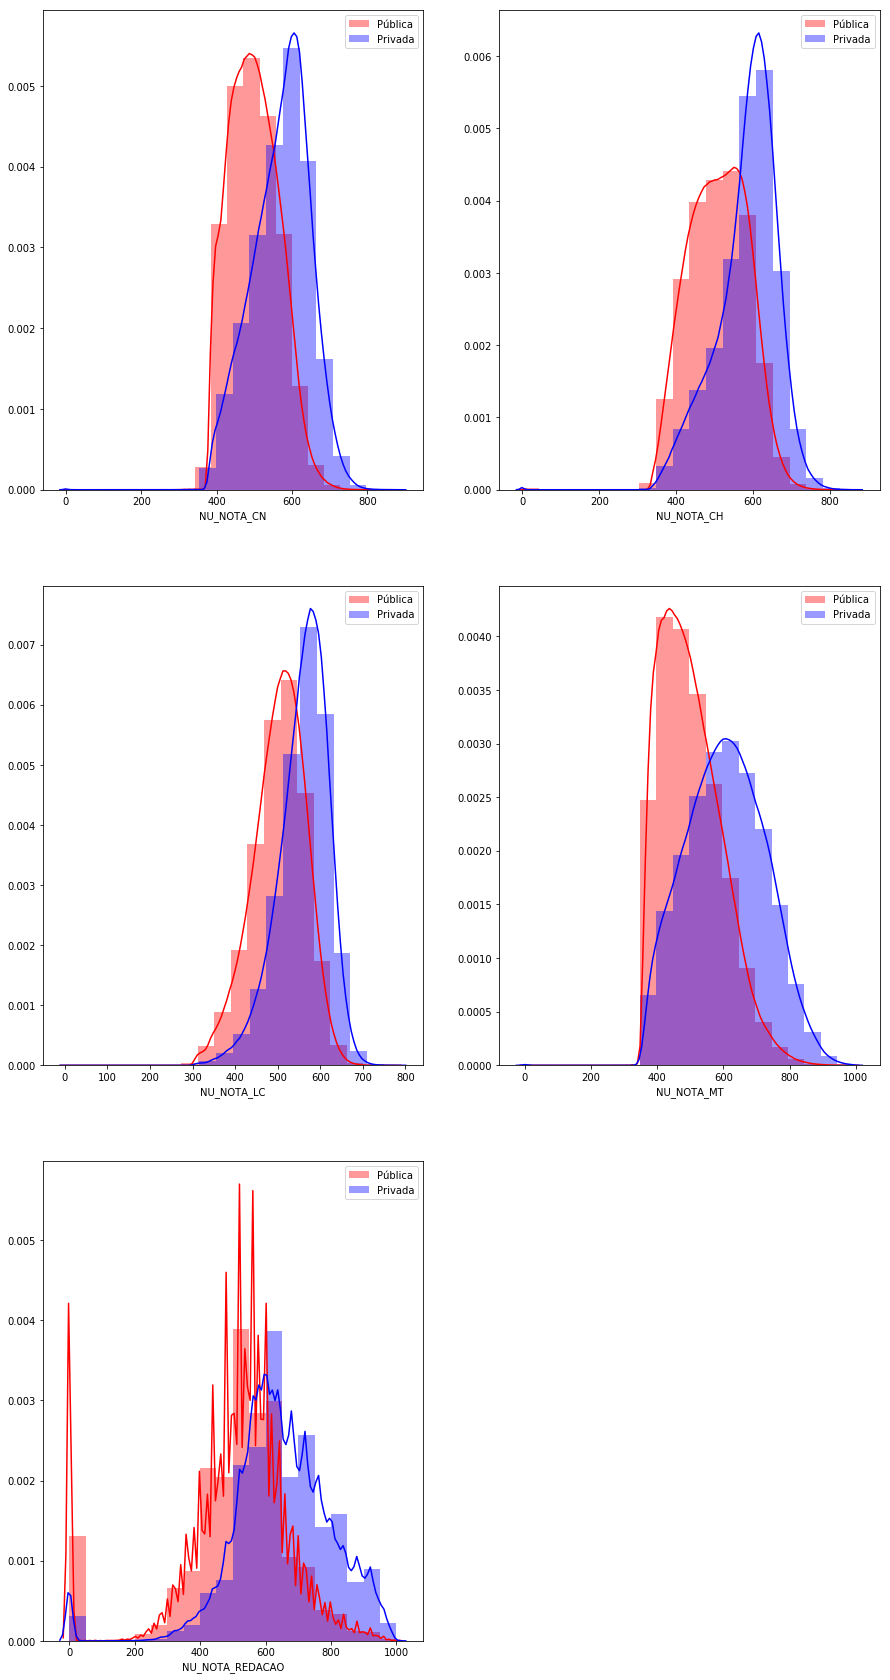

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
Q027,,,,,
A,3483944,3483944,3483944,3483944,3483944
B,150856,150856,150856,150856,150856
C,71085,71085,71085,71085,71085
D,590068,590068,590068,590068,590068
E,130801,130801,130801,130801,130801


In [59]:
##escola pública vs privada
df_pb = df[(df["Q027"] == "A")| (df["Q027"] == "B")| (df["Q027"] == "C")]
df_pv = df[(df["Q027"] == "D") | (df["Q027"] == "E")]
bins = 20
plt.figure(figsize=(15,30))
rows = 3
for i, col in enumerate(notas):
    plt.subplot(rows, 2, i+1)
    sns.distplot(df_pb[col], bins=bins, color='red', label='Pública');
    sns.distplot(df_pv[col], bins=bins, color='blue', label='Privada');
    plt.legend(loc='upper right')
    print("{}: média Pública: {:.2f} ".format(col, df_pb[col].mean()))
    print("{}: média Privada: {:.2f}".format(col, df_pv[col].mean()))

plt.savefig("escola.jpg",dpi = 100)
plt.show()
df.groupby("Q027").count()



In [55]:
# considerando como classe 0 = qualquer momento em escola pública, 1 = sempre escola privada
df_clean = df.replace({"Q027":{"A":0,"B":0,"C":0,"D":1,"E":1}})

#undersampling da classe publica, rebalanceamento dos dados
df_pubc = df_clean[(df_clean["Q027"] == 0)]
df_pric = df_clean[(df_clean["Q027"] == 1)]

df_pubc = df_pubc.sample(150000, random_state = 0)
df_pric = df_pric.sample(150000,random_state = 0)

df_clean = pd.concat([df_pubc,df_pric], axis = 0)

#df_pric.shape[0]

X = df_clean[notas]
Y = df_clean.loc[:,"Q027"]

X_1, X_2, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

scaler = preprocessing.StandardScaler().fit(X_1)

X_train = scaler.transform(X_1)
X_test = scaler.transform(X_2)



In [38]:
param = {"n_neighbors" : list(range(20,35))}

grid = GridSearchCV(KNeighborsClassifier(n_neighbors = 5), param, scoring = "accuracy",cv = 5, n_jobs = -1)

grid.fit (X_1,y_train)

print("Melhor parâmetro: {} ".format(grid.best_params_))
print("Melhor score: {}".format(grid.best_score_))

print("Acurácia no conjunto de teste: {}".format(accuracy_score(y_test,grid.predict(X_2))))

print(classification_report(y_test,grid.predict(X_2), target_names = ["Publica","Privada"]))

/home/vinicius/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/vinicius/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/vinicius/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/vinicius/anaconda3/lib/python3.6/site-packages/sklearn/externals/jobli

Melhor parâmetro: {'n_neighbors': 34} 
Melhor score: 0.7306466666666667
Acurácia no conjunto de teste: 0.72864
              precision    recall  f1-score   support

     Publica       0.71      0.77      0.74     24876
     Privada       0.75      0.68      0.72     25124

   micro avg       0.73      0.73      0.73     50000
   macro avg       0.73      0.73      0.73     50000
weighted avg       0.73      0.73      0.73     50000



In [56]:
logi = LogisticRegressionCV(fit_intercept = True, scoring = 'accuracy', cv = 5, random_state = 0)

logi.fit(X_1, y_train)

print("Acurácia regressão logistica no conjunto de teste: {}".format(logi.score(X_2,y_test)))
print("Coeficientes regressão logística: {}".format(logi.coef_))
print("Intersecção regressão logística: {}".format(logi.intercept_))

print(classification_report(y_test,logi.predict(X_2), target_names = ["Publica","Privada"]))

Acurácia regressão logistica no conjunto de teste: 0.7348666666666667
Coeficientes regressão logística: [[0.00570018 0.00172493 0.00334215 0.00383403 0.00241141]]
              precision    recall  f1-score   support

     Publica       0.73      0.75      0.74     37622
     Privada       0.74      0.72      0.73     37378

   micro avg       0.73      0.73      0.73     75000
   macro avg       0.73      0.73      0.73     75000
weighted avg       0.73      0.73      0.73     75000



/home/vinicius/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1926: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


In [58]:
teste = np.array([[400,400,400,400,400],
                                  [500,500,500,500,500],
                                  [600,600,600,600,600],
                                  [700,700,700,700,700],
                                  [800,800,800,800,800]])

prob = logi.predict_proba(teste)

print(" Probabilidades para notas uniformes: \n 400: {} \n 500: {}  \n 600: {} \n 700: {} \n 800: {}".format(prob[0],prob[1],prob[2],prob[3],prob[4]))

Intersecção regressão logística: [-9.2487159]
 Probabilidades para notas uniformes: 
 400: [0.92009504 0.07990496] 
 500: [0.67751385 0.32248615]  
 600: [0.27709861 0.72290139] 
 700: [0.06536503 0.93463497] 
 800: [0.01259926 0.98740074]
